In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        self.check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if (iteration % self.check_point == 0) & (iteration > 0):
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [3]:
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

In [4]:
# Initial a neural net
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
def leap_frog(q, p, dUdq, n_steps, step_size):
    q = np.copy(q)
    p = np.copy(p) # protect the current value of q and p
    
    # half-step update for momentum at the beginning
    p = p - step_size/2 * dUdq(q)
    
    for _ in range(n_steps - 1):
        q = q + step_size * p 
        p = p - step_size * dUdq(q)
    
    # full-step update for position:
    q = q + step_size * p 
    # half-step update for momentum at the end:
    p = p - step_size/2 * dUdq(q) 
    
    # reverse momentum
    return q, -p

In [6]:
def get_HMC(U_function, params):
    """
    Input
    ----------    
    U_function : func
    params: a dictionary, containing key-value pairs as follows:
        step_size: float
        leapfrog_steps: int
        total_samples: int
        burn_in: float
        thinning_factor: int
        position_init: np.array, with shape (D, )


    Output
    -------
    np.array, with shape (n_samples_clean, D)
    """
    # read parameters
    step_size = params['step_size']
    leapfrog_steps = params['leapfrog_steps']
    total_samples = params['total_samples']
    burn_in = params['burn_in']
    thinning_factor = params['thinning_factor']
    position_init = params['position_init']

    dUdq = grad(U_function) # define dUdq   
    
    samples = list([position_init]) 
    size = (total_samples, ) + (position_init.shape[-1], ) # define the size of output
    
    momentum = st.norm(0, 1)
    for p0 in momentum.rvs(size = size): # directly generate moments for shape (n_samples, n_params)
        # Leap-Frog Integration
        q_new, p_new = leap_frog(samples[-1], p0, dUdq, leapfrog_steps, step_size)

        # correction for simulation error
        cur_total = U_function(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_total = U_function(q_new) - np.sum(momentum.logpdf(p_new))
        
        alpha = min(1, np.exp(cur_total - new_total))
        u = np.random.uniform(0,1)
        
        if u <= alpha:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))
        if (len(samples) - 1) % 100 == 0:
            print('{} Samples'.format(len(samples) - 1))
    
    output_samples = np.array(samples[1:]).reshape(total_samples, position_init.shape[-1]) 
    
    return output_samples[int(burn_in * total_samples)::thinning_factor]


In [7]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 100 lower bound 52.864360467566954; gradient mag: 56.954586390884565
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.31175187956584
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.1925753228009
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190933
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866592
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044558814075
Iteration 1300 lower bound 16.967826824623163; gradient mag: 14.0

Iteration 10500 lower bound 0.9103442477143842; gradient mag: 0.018967289476139248
Iteration 10600 lower bound 0.909843795785039; gradient mag: 0.0260208775414213
Iteration 10700 lower bound 0.9093412773629563; gradient mag: 0.018346019412784895
Iteration 10800 lower bound 0.9088375478661561; gradient mag: 0.017507234788555835
Iteration 10900 lower bound 0.908333256977938; gradient mag: 0.017022403306550412
Iteration 11000 lower bound 0.9078291212411638; gradient mag: 0.01653756998775371
Iteration 11100 lower bound 0.9073258593597671; gradient mag: 0.01605318099589729
Iteration 11200 lower bound 0.906880280043499; gradient mag: 0.5191583565196869
Iteration 11300 lower bound 0.9063248877779713; gradient mag: 0.01532828460652032
Iteration 11400 lower bound 0.9058285594590852; gradient mag: 0.014606410461076153
Iteration 11500 lower bound 0.9053358942388462; gradient mag: 0.014131053424309887
Iteration 11600 lower bound 0.9048475523685143; gradient mag: 0.013659494904968887
Iteration 1170

In [15]:
# Use HW7 Solution
x_train = x.reshape(1, -1)
y_train = y.reshape(1, -1)

###Bayesian model parameterss
#covariance matrix of the Gaussian prior on weights
Sigma_W = 5**2 * np.eye(nn.D)
#Gaussian likelihood std
sigma_y = 0.5
#number of data points
N = 12
#precision matrix of the Gaussian prior on weights
Sigma_W_inv = np.linalg.inv(Sigma_W)
#determinant of the covaraince matrix of the Gaussian prior on weights
Sigma_W_det = np.linalg.det(Sigma_W)

###definition of the log prior
def log_prior(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = len(W)
    constant_W = -0.5 * (nn.D * np.log(2 * np.pi) + np.log(Sigma_W_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
    assert exponential_W.shape == (S, )
    log_p_W = constant_W + exponential_W
    return log_p_W

###definition of the log likelihood
def log_lklhd(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = W.shape[0]
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - nn.forward(W, x_train))**2, axis=2).flatten()
    assert exponential.shape == (S, )
    return constant + exponential

def joint_log_nn(W):
    return log_prior(W) + log_lklhd(W)

In [23]:
params_nn_converge = {'step_size':0.01, 
          'leapfrog_steps':10, 
          'total_samples':500000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights.reshape((1, nn.D))}

U_function_nn = lambda W: -joint_log_nn(W)

In [24]:
def get_HMC(U_function, params):
    """
    Input
    ----------    
    U_function : func
    params: a dictionary, containing key-value pairs as follows:
        step_size: float
        leapfrog_steps: int
        total_samples: int
        burn_in: float
        thinning_factor: int
        position_init: np.array, with shape (D, )


    Output
    -------
    np.array, with shape (n_samples_clean, D)
    """
    # read parameters
    step_size = params['step_size']
    leapfrog_steps = params['leapfrog_steps']
    total_samples = params['total_samples']
    burn_in = params['burn_in']
    thinning_factor = params['thinning_factor']
    position_init = params['position_init']

    dUdq = grad(U_function) # define dUdq   
    
    samples = list([position_init]) 
    size = (total_samples, ) + (position_init.shape[-1], ) # define the size of output
    
    momentum = st.norm(0, 1)
    alpha_list = []
    for p0 in momentum.rvs(size = size): # directly generate moments for shape (n_samples, n_params)
        # Leap-Frog Integration
        q_new, p_new = leap_frog(samples[-1], p0, dUdq, leapfrog_steps, step_size)

        # correction for simulation error
        cur_total = U_function(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_total = U_function(q_new) - np.sum(momentum.logpdf(p_new))
        
        alpha = min(1, np.exp(cur_total - new_total))
        u = np.random.uniform(0,1)
        
        # constantly adjust the step_size according to acceptance rate
        if alpha < 0.5:
            step_size -= (0.5 - float(alpha)) * 0.005
        elif alpha > 0.7:
            step_size += (float(alpha) - 0.7) * 0.005
        alpha_list.append(alpha)
        
        if u <= alpha:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))
        if (len(samples) - 1) % 100 == 0:
            print('{0} Samples. Acceptance Rate: {1:6.2f} % step_size : {2:6.4f}'.format(len(samples)-1, float(np.mean(alpha_list[len(samples)-101:len(samples)-1]) * 100), step_size))
    
    output_samples = np.array(samples[1:]).reshape(total_samples, position_init.shape[-1]) 
    
    return output_samples[int(burn_in * total_samples)::thinning_factor]

In [25]:
begin=time.time()
np.random.seed(2019)
samples_nn_HMC_converge = get_HMC(U_function_nn, params_nn_converge)
end=time.time()

100 Samples. Acceptance Rate:  62.50 % step_size : 0.0125
200 Samples. Acceptance Rate:  62.16 % step_size : 0.0158
300 Samples. Acceptance Rate:  63.55 % step_size : 0.0252
400 Samples. Acceptance Rate:  61.86 % step_size : 0.0238
500 Samples. Acceptance Rate:  60.43 % step_size : 0.0190
600 Samples. Acceptance Rate:  62.87 % step_size : 0.0211
700 Samples. Acceptance Rate:  62.13 % step_size : 0.0225
800 Samples. Acceptance Rate:  62.78 % step_size : 0.0295
900 Samples. Acceptance Rate:  61.22 % step_size : 0.0282
1000 Samples. Acceptance Rate:  60.05 % step_size : 0.0225
1100 Samples. Acceptance Rate:  60.95 % step_size : 0.0208
1200 Samples. Acceptance Rate:  63.55 % step_size : 0.0258
1300 Samples. Acceptance Rate:  62.44 % step_size : 0.0298
1400 Samples. Acceptance Rate:  61.70 % step_size : 0.0264
1500 Samples. Acceptance Rate:  61.30 % step_size : 0.0240
1600 Samples. Acceptance Rate:  60.17 % step_size : 0.0172
1700 Samples. Acceptance Rate:  64.04 % step_size : 0.0254
1800 S

14000 Samples. Acceptance Rate:  60.71 % step_size : 0.0101
14100 Samples. Acceptance Rate:  62.08 % step_size : 0.0085
14200 Samples. Acceptance Rate:  63.05 % step_size : 0.0108
14300 Samples. Acceptance Rate:  62.06 % step_size : 0.0099
14400 Samples. Acceptance Rate:  62.56 % step_size : 0.0131
14500 Samples. Acceptance Rate:  61.48 % step_size : 0.0100
14600 Samples. Acceptance Rate:  62.50 % step_size : 0.0101
14700 Samples. Acceptance Rate:  62.70 % step_size : 0.0105
14800 Samples. Acceptance Rate:  63.17 % step_size : 0.0158
14900 Samples. Acceptance Rate:  63.98 % step_size : 0.0243
15000 Samples. Acceptance Rate:  62.42 % step_size : 0.0264
15100 Samples. Acceptance Rate:  62.06 % step_size : 0.0261
15200 Samples. Acceptance Rate:  60.82 % step_size : 0.0214
15300 Samples. Acceptance Rate:  62.89 % step_size : 0.0207
15400 Samples. Acceptance Rate:  64.47 % step_size : 0.0268
15500 Samples. Acceptance Rate:  60.69 % step_size : 0.0211
15600 Samples. Acceptance Rate:  61.95 %

27700 Samples. Acceptance Rate:  61.26 % step_size : 0.0184
27800 Samples. Acceptance Rate:  62.96 % step_size : 0.0225
27900 Samples. Acceptance Rate:  60.89 % step_size : 0.0170
28000 Samples. Acceptance Rate:  61.83 % step_size : 0.0143
28100 Samples. Acceptance Rate:  61.79 % step_size : 0.0146
28200 Samples. Acceptance Rate:  60.37 % step_size : 0.0104
28300 Samples. Acceptance Rate:  63.62 % step_size : 0.0178
28400 Samples. Acceptance Rate:  62.75 % step_size : 0.0226
28500 Samples. Acceptance Rate:  62.24 % step_size : 0.0227
28600 Samples. Acceptance Rate:  62.59 % step_size : 0.0242
28700 Samples. Acceptance Rate:  61.77 % step_size : 0.0222
28800 Samples. Acceptance Rate:  60.80 % step_size : 0.0204
28900 Samples. Acceptance Rate:  61.80 % step_size : 0.0192
29000 Samples. Acceptance Rate:  63.37 % step_size : 0.0235
29100 Samples. Acceptance Rate:  60.55 % step_size : 0.0189
29200 Samples. Acceptance Rate:  63.43 % step_size : 0.0239
29300 Samples. Acceptance Rate:  65.05 %

41400 Samples. Acceptance Rate:  63.21 % step_size : 0.0233
41500 Samples. Acceptance Rate:  61.68 % step_size : 0.0232
41600 Samples. Acceptance Rate:  62.61 % step_size : 0.0246
41700 Samples. Acceptance Rate:  62.11 % step_size : 0.0249
41800 Samples. Acceptance Rate:  61.78 % step_size : 0.0228
41900 Samples. Acceptance Rate:  62.18 % step_size : 0.0213
42000 Samples. Acceptance Rate:  62.77 % step_size : 0.0257
42100 Samples. Acceptance Rate:  61.97 % step_size : 0.0242
42200 Samples. Acceptance Rate:  63.08 % step_size : 0.0296
42300 Samples. Acceptance Rate:  60.71 % step_size : 0.0234
42400 Samples. Acceptance Rate:  61.97 % step_size : 0.0207
42500 Samples. Acceptance Rate:  60.92 % step_size : 0.0172
42600 Samples. Acceptance Rate:  61.13 % step_size : 0.0146
42700 Samples. Acceptance Rate:  61.62 % step_size : 0.0121
42800 Samples. Acceptance Rate:  63.50 % step_size : 0.0212
42900 Samples. Acceptance Rate:  63.99 % step_size : 0.0276
43000 Samples. Acceptance Rate:  59.75 %

55100 Samples. Acceptance Rate:  62.29 % step_size : 0.0260
55200 Samples. Acceptance Rate:  57.67 % step_size : 0.0116
55300 Samples. Acceptance Rate:  62.12 % step_size : 0.0128
55400 Samples. Acceptance Rate:  63.64 % step_size : 0.0197
55500 Samples. Acceptance Rate:  61.60 % step_size : 0.0190
55600 Samples. Acceptance Rate:  62.07 % step_size : 0.0225
55700 Samples. Acceptance Rate:  61.42 % step_size : 0.0209
55800 Samples. Acceptance Rate:  61.54 % step_size : 0.0226
55900 Samples. Acceptance Rate:  62.29 % step_size : 0.0234
56000 Samples. Acceptance Rate:  62.93 % step_size : 0.0283
56100 Samples. Acceptance Rate:  61.10 % step_size : 0.0229
56200 Samples. Acceptance Rate:  61.34 % step_size : 0.0210
56300 Samples. Acceptance Rate:  63.88 % step_size : 0.0281
56400 Samples. Acceptance Rate:  62.67 % step_size : 0.0339
56500 Samples. Acceptance Rate:  59.44 % step_size : 0.0234
56600 Samples. Acceptance Rate:  59.54 % step_size : 0.0144
56700 Samples. Acceptance Rate:  65.10 %

68800 Samples. Acceptance Rate:  59.63 % step_size : 0.0195
68900 Samples. Acceptance Rate:  63.83 % step_size : 0.0256
69000 Samples. Acceptance Rate:  63.18 % step_size : 0.0283
69100 Samples. Acceptance Rate:  60.33 % step_size : 0.0215
69200 Samples. Acceptance Rate:  61.32 % step_size : 0.0208
69300 Samples. Acceptance Rate:  61.60 % step_size : 0.0179
69400 Samples. Acceptance Rate:  62.33 % step_size : 0.0180
69500 Samples. Acceptance Rate:  60.35 % step_size : 0.0119
69600 Samples. Acceptance Rate:  63.78 % step_size : 0.0206
69700 Samples. Acceptance Rate:  62.00 % step_size : 0.0208
69800 Samples. Acceptance Rate:  63.06 % step_size : 0.0234
69900 Samples. Acceptance Rate:  60.93 % step_size : 0.0173
70000 Samples. Acceptance Rate:  64.55 % step_size : 0.0268
70100 Samples. Acceptance Rate:  61.30 % step_size : 0.0241
70200 Samples. Acceptance Rate:  62.12 % step_size : 0.0228
70300 Samples. Acceptance Rate:  62.81 % step_size : 0.0258
70400 Samples. Acceptance Rate:  60.78 %

82500 Samples. Acceptance Rate:  64.13 % step_size : 0.0246
82600 Samples. Acceptance Rate:  61.92 % step_size : 0.0247
82700 Samples. Acceptance Rate:  62.29 % step_size : 0.0257
82800 Samples. Acceptance Rate:  61.95 % step_size : 0.0250
82900 Samples. Acceptance Rate:  63.00 % step_size : 0.0267
83000 Samples. Acceptance Rate:  59.17 % step_size : 0.0184
83100 Samples. Acceptance Rate:  63.20 % step_size : 0.0218
83200 Samples. Acceptance Rate:  61.75 % step_size : 0.0200
83300 Samples. Acceptance Rate:  62.43 % step_size : 0.0235
83400 Samples. Acceptance Rate:  61.22 % step_size : 0.0205
83500 Samples. Acceptance Rate:  64.98 % step_size : 0.0359
83600 Samples. Acceptance Rate:  60.60 % step_size : 0.0282
83700 Samples. Acceptance Rate:  62.69 % step_size : 0.0290
83800 Samples. Acceptance Rate:  63.85 % step_size : 0.0352
83900 Samples. Acceptance Rate:  60.49 % step_size : 0.0325
84000 Samples. Acceptance Rate:  59.32 % step_size : 0.0234
84100 Samples. Acceptance Rate:  65.05 %

96200 Samples. Acceptance Rate:  62.72 % step_size : 0.0305
96300 Samples. Acceptance Rate:  60.28 % step_size : 0.0220
96400 Samples. Acceptance Rate:  62.85 % step_size : 0.0240
96500 Samples. Acceptance Rate:  60.53 % step_size : 0.0170
96600 Samples. Acceptance Rate:  62.60 % step_size : 0.0197
96700 Samples. Acceptance Rate:  63.31 % step_size : 0.0233
96800 Samples. Acceptance Rate:  58.91 % step_size : 0.0111
96900 Samples. Acceptance Rate:  62.88 % step_size : 0.0142
97000 Samples. Acceptance Rate:  64.50 % step_size : 0.0256
97100 Samples. Acceptance Rate:  61.07 % step_size : 0.0195
97200 Samples. Acceptance Rate:  60.02 % step_size : 0.0118
97300 Samples. Acceptance Rate:  64.76 % step_size : 0.0255
97400 Samples. Acceptance Rate:  60.33 % step_size : 0.0189
97500 Samples. Acceptance Rate:  61.90 % step_size : 0.0195
97600 Samples. Acceptance Rate:  64.10 % step_size : 0.0254
97700 Samples. Acceptance Rate:  60.20 % step_size : 0.0177
97800 Samples. Acceptance Rate:  62.29 %

109700 Samples. Acceptance Rate:  62.61 % step_size : 0.0177
109800 Samples. Acceptance Rate:  62.31 % step_size : 0.0191
109900 Samples. Acceptance Rate:  63.33 % step_size : 0.0238
110000 Samples. Acceptance Rate:  59.46 % step_size : 0.0157
110100 Samples. Acceptance Rate:  63.75 % step_size : 0.0221
110200 Samples. Acceptance Rate:  61.90 % step_size : 0.0216
110300 Samples. Acceptance Rate:  62.12 % step_size : 0.0226
110400 Samples. Acceptance Rate:  62.01 % step_size : 0.0229
110500 Samples. Acceptance Rate:  61.59 % step_size : 0.0223
110600 Samples. Acceptance Rate:  60.74 % step_size : 0.0185
110700 Samples. Acceptance Rate:  63.37 % step_size : 0.0255
110800 Samples. Acceptance Rate:  62.83 % step_size : 0.0258
110900 Samples. Acceptance Rate:  60.35 % step_size : 0.0187
111000 Samples. Acceptance Rate:  61.95 % step_size : 0.0209
111100 Samples. Acceptance Rate:  62.15 % step_size : 0.0198
111200 Samples. Acceptance Rate:  60.12 % step_size : 0.0125
111300 Samples. Acceptan

123200 Samples. Acceptance Rate:  62.83 % step_size : 0.0268
123300 Samples. Acceptance Rate:  61.94 % step_size : 0.0250
123400 Samples. Acceptance Rate:  62.05 % step_size : 0.0228
123500 Samples. Acceptance Rate:  62.34 % step_size : 0.0230
123600 Samples. Acceptance Rate:  62.84 % step_size : 0.0255
123700 Samples. Acceptance Rate:  60.26 % step_size : 0.0191
123800 Samples. Acceptance Rate:  61.26 % step_size : 0.0172
123900 Samples. Acceptance Rate:  62.18 % step_size : 0.0173
124000 Samples. Acceptance Rate:  62.28 % step_size : 0.0200
124100 Samples. Acceptance Rate:  62.06 % step_size : 0.0190
124200 Samples. Acceptance Rate:  64.83 % step_size : 0.0275
124300 Samples. Acceptance Rate:  62.16 % step_size : 0.0268
124400 Samples. Acceptance Rate:  62.33 % step_size : 0.0263
124500 Samples. Acceptance Rate:  61.07 % step_size : 0.0227
124600 Samples. Acceptance Rate:  62.97 % step_size : 0.0279
124700 Samples. Acceptance Rate:  61.49 % step_size : 0.0249
124800 Samples. Acceptan

136700 Samples. Acceptance Rate:  62.12 % step_size : 0.0232
136800 Samples. Acceptance Rate:  61.66 % step_size : 0.0217
136900 Samples. Acceptance Rate:  62.09 % step_size : 0.0235
137000 Samples. Acceptance Rate:  61.71 % step_size : 0.0208
137100 Samples. Acceptance Rate:  63.17 % step_size : 0.0255
137200 Samples. Acceptance Rate:  59.16 % step_size : 0.0157
137300 Samples. Acceptance Rate:  64.76 % step_size : 0.0257
137400 Samples. Acceptance Rate:  62.44 % step_size : 0.0248
137500 Samples. Acceptance Rate:  62.50 % step_size : 0.0253
137600 Samples. Acceptance Rate:  60.53 % step_size : 0.0171
137700 Samples. Acceptance Rate:  62.46 % step_size : 0.0174
137800 Samples. Acceptance Rate:  63.80 % step_size : 0.0232
137900 Samples. Acceptance Rate:  62.37 % step_size : 0.0241
138000 Samples. Acceptance Rate:  60.54 % step_size : 0.0182
138100 Samples. Acceptance Rate:  61.67 % step_size : 0.0159
138200 Samples. Acceptance Rate:  64.07 % step_size : 0.0238
138300 Samples. Acceptan

150200 Samples. Acceptance Rate:  62.50 % step_size : 0.0073
150300 Samples. Acceptance Rate:  63.12 % step_size : 0.0089
150400 Samples. Acceptance Rate:  62.05 % step_size : 0.0082
150500 Samples. Acceptance Rate:  61.73 % step_size : 0.0091
150600 Samples. Acceptance Rate:  62.03 % step_size : 0.0104
150700 Samples. Acceptance Rate:  61.20 % step_size : 0.0082
150800 Samples. Acceptance Rate:  62.20 % step_size : 0.0096
150900 Samples. Acceptance Rate:  62.42 % step_size : 0.0112
151000 Samples. Acceptance Rate:  60.69 % step_size : 0.0073
151100 Samples. Acceptance Rate:  62.64 % step_size : 0.0095
151200 Samples. Acceptance Rate:  60.88 % step_size : 0.0072
151300 Samples. Acceptance Rate:  62.67 % step_size : 0.0100
151400 Samples. Acceptance Rate:  61.85 % step_size : 0.0090
151500 Samples. Acceptance Rate:  62.08 % step_size : 0.0103
151600 Samples. Acceptance Rate:  62.85 % step_size : 0.0107
151700 Samples. Acceptance Rate:  62.86 % step_size : 0.0128
151800 Samples. Acceptan

163700 Samples. Acceptance Rate:  62.60 % step_size : 0.0208
163800 Samples. Acceptance Rate:  61.86 % step_size : 0.0219
163900 Samples. Acceptance Rate:  62.59 % step_size : 0.0250
164000 Samples. Acceptance Rate:  61.35 % step_size : 0.0260
164100 Samples. Acceptance Rate:  61.93 % step_size : 0.0249
164200 Samples. Acceptance Rate:  63.58 % step_size : 0.0282
164300 Samples. Acceptance Rate:  59.47 % step_size : 0.0183
164400 Samples. Acceptance Rate:  64.45 % step_size : 0.0285
164500 Samples. Acceptance Rate:  60.26 % step_size : 0.0215
164600 Samples. Acceptance Rate:  59.53 % step_size : 0.0130
164700 Samples. Acceptance Rate:  64.02 % step_size : 0.0245
164800 Samples. Acceptance Rate:  59.82 % step_size : 0.0168
164900 Samples. Acceptance Rate:  64.12 % step_size : 0.0258
165000 Samples. Acceptance Rate:  63.66 % step_size : 0.0322
165100 Samples. Acceptance Rate:  60.86 % step_size : 0.0247
165200 Samples. Acceptance Rate:  63.86 % step_size : 0.0323
165300 Samples. Acceptan

177200 Samples. Acceptance Rate:  62.98 % step_size : 0.0257
177300 Samples. Acceptance Rate:  61.37 % step_size : 0.0243
177400 Samples. Acceptance Rate:  59.20 % step_size : 0.0139
177500 Samples. Acceptance Rate:  63.63 % step_size : 0.0207
177600 Samples. Acceptance Rate:  63.75 % step_size : 0.0278
177700 Samples. Acceptance Rate:  61.69 % step_size : 0.0247
177800 Samples. Acceptance Rate:  62.75 % step_size : 0.0315
177900 Samples. Acceptance Rate:  61.33 % step_size : 0.0291
178000 Samples. Acceptance Rate:  63.42 % step_size : 0.0376
178100 Samples. Acceptance Rate:  60.55 % step_size : 0.0315
178200 Samples. Acceptance Rate:  60.29 % step_size : 0.0215
178300 Samples. Acceptance Rate:  62.16 % step_size : 0.0212
178400 Samples. Acceptance Rate:  59.17 % step_size : 0.0100
178500 Samples. Acceptance Rate:  63.42 % step_size : 0.0160
178600 Samples. Acceptance Rate:  60.98 % step_size : 0.0140
178700 Samples. Acceptance Rate:  60.97 % step_size : 0.0085
178800 Samples. Acceptan

190700 Samples. Acceptance Rate:  61.77 % step_size : 0.0264
190800 Samples. Acceptance Rate:  61.46 % step_size : 0.0233
190900 Samples. Acceptance Rate:  61.24 % step_size : 0.0202
191000 Samples. Acceptance Rate:  61.47 % step_size : 0.0197
191100 Samples. Acceptance Rate:  63.12 % step_size : 0.0259
191200 Samples. Acceptance Rate:  60.16 % step_size : 0.0205
191300 Samples. Acceptance Rate:  65.04 % step_size : 0.0300
191400 Samples. Acceptance Rate:  60.01 % step_size : 0.0211
191500 Samples. Acceptance Rate:  61.54 % step_size : 0.0187
191600 Samples. Acceptance Rate:  61.88 % step_size : 0.0205
191700 Samples. Acceptance Rate:  61.24 % step_size : 0.0195
191800 Samples. Acceptance Rate:  60.46 % step_size : 0.0155
191900 Samples. Acceptance Rate:  65.44 % step_size : 0.0261
192000 Samples. Acceptance Rate:  61.46 % step_size : 0.0222
192100 Samples. Acceptance Rate:  61.60 % step_size : 0.0217
192200 Samples. Acceptance Rate:  60.53 % step_size : 0.0182
192300 Samples. Acceptan

204200 Samples. Acceptance Rate:  61.40 % step_size : 0.0181
204300 Samples. Acceptance Rate:  63.29 % step_size : 0.0230
204400 Samples. Acceptance Rate:  60.41 % step_size : 0.0155
204500 Samples. Acceptance Rate:  64.31 % step_size : 0.0231
204600 Samples. Acceptance Rate:  62.96 % step_size : 0.0301
204700 Samples. Acceptance Rate:  61.47 % step_size : 0.0256
204800 Samples. Acceptance Rate:  62.36 % step_size : 0.0256
204900 Samples. Acceptance Rate:  61.24 % step_size : 0.0225
205000 Samples. Acceptance Rate:  62.71 % step_size : 0.0222
205100 Samples. Acceptance Rate:  62.20 % step_size : 0.0217
205200 Samples. Acceptance Rate:  63.71 % step_size : 0.0269
205300 Samples. Acceptance Rate:  61.37 % step_size : 0.0248
205400 Samples. Acceptance Rate:  61.94 % step_size : 0.0204
205500 Samples. Acceptance Rate:  61.17 % step_size : 0.0173
205600 Samples. Acceptance Rate:  62.93 % step_size : 0.0206
205700 Samples. Acceptance Rate:  62.75 % step_size : 0.0234
205800 Samples. Acceptan

217700 Samples. Acceptance Rate:  63.63 % step_size : 0.0252
217800 Samples. Acceptance Rate:  60.68 % step_size : 0.0186
217900 Samples. Acceptance Rate:  64.36 % step_size : 0.0253
218000 Samples. Acceptance Rate:  62.71 % step_size : 0.0276
218100 Samples. Acceptance Rate:  59.78 % step_size : 0.0184
218200 Samples. Acceptance Rate:  62.97 % step_size : 0.0205
218300 Samples. Acceptance Rate:  59.03 % step_size : 0.0089
218400 Samples. Acceptance Rate:  61.81 % step_size : 0.0090
218500 Samples. Acceptance Rate:  62.06 % step_size : 0.0103
218600 Samples. Acceptance Rate:  62.99 % step_size : 0.0152
218700 Samples. Acceptance Rate:  63.84 % step_size : 0.0225
218800 Samples. Acceptance Rate:  61.44 % step_size : 0.0198
218900 Samples. Acceptance Rate:  61.33 % step_size : 0.0183
219000 Samples. Acceptance Rate:  60.93 % step_size : 0.0156
219100 Samples. Acceptance Rate:  64.63 % step_size : 0.0247
219200 Samples. Acceptance Rate:  60.17 % step_size : 0.0177
219300 Samples. Acceptan

231200 Samples. Acceptance Rate:  63.94 % step_size : 0.0251
231300 Samples. Acceptance Rate:  61.21 % step_size : 0.0245
231400 Samples. Acceptance Rate:  62.73 % step_size : 0.0274
231500 Samples. Acceptance Rate:  61.46 % step_size : 0.0250
231600 Samples. Acceptance Rate:  61.75 % step_size : 0.0255
231700 Samples. Acceptance Rate:  62.55 % step_size : 0.0269
231800 Samples. Acceptance Rate:  61.99 % step_size : 0.0266
231900 Samples. Acceptance Rate:  60.92 % step_size : 0.0217
232000 Samples. Acceptance Rate:  62.53 % step_size : 0.0229
232100 Samples. Acceptance Rate:  63.45 % step_size : 0.0267
232200 Samples. Acceptance Rate:  60.33 % step_size : 0.0193
232300 Samples. Acceptance Rate:  61.33 % step_size : 0.0160
232400 Samples. Acceptance Rate:  63.34 % step_size : 0.0246
232500 Samples. Acceptance Rate:  61.80 % step_size : 0.0261
232600 Samples. Acceptance Rate:  60.05 % step_size : 0.0205
232700 Samples. Acceptance Rate:  64.28 % step_size : 0.0307
232800 Samples. Acceptan

244700 Samples. Acceptance Rate:  64.25 % step_size : 0.0225
244800 Samples. Acceptance Rate:  63.22 % step_size : 0.0253
244900 Samples. Acceptance Rate:  62.58 % step_size : 0.0232
245000 Samples. Acceptance Rate:  61.94 % step_size : 0.0240
245100 Samples. Acceptance Rate:  62.12 % step_size : 0.0218
245200 Samples. Acceptance Rate:  60.48 % step_size : 0.0143
245300 Samples. Acceptance Rate:  63.92 % step_size : 0.0221
245400 Samples. Acceptance Rate:  61.23 % step_size : 0.0224
245500 Samples. Acceptance Rate:  61.65 % step_size : 0.0205
245600 Samples. Acceptance Rate:  63.70 % step_size : 0.0268
245700 Samples. Acceptance Rate:  60.95 % step_size : 0.0207
245800 Samples. Acceptance Rate:  61.15 % step_size : 0.0186
245900 Samples. Acceptance Rate:  62.78 % step_size : 0.0217
246000 Samples. Acceptance Rate:  62.92 % step_size : 0.0246
246100 Samples. Acceptance Rate:  59.74 % step_size : 0.0152
246200 Samples. Acceptance Rate:  62.68 % step_size : 0.0172
246300 Samples. Acceptan

258200 Samples. Acceptance Rate:  61.83 % step_size : 0.0230
258300 Samples. Acceptance Rate:  62.67 % step_size : 0.0255
258400 Samples. Acceptance Rate:  60.39 % step_size : 0.0187
258500 Samples. Acceptance Rate:  61.30 % step_size : 0.0152
258600 Samples. Acceptance Rate:  64.90 % step_size : 0.0256
258700 Samples. Acceptance Rate:  59.49 % step_size : 0.0147
258800 Samples. Acceptance Rate:  61.74 % step_size : 0.0152
258900 Samples. Acceptance Rate:  64.33 % step_size : 0.0207
259000 Samples. Acceptance Rate:  61.54 % step_size : 0.0192
259100 Samples. Acceptance Rate:  61.34 % step_size : 0.0160
259200 Samples. Acceptance Rate:  63.90 % step_size : 0.0229
259300 Samples. Acceptance Rate:  59.94 % step_size : 0.0157
259400 Samples. Acceptance Rate:  62.76 % step_size : 0.0181
259500 Samples. Acceptance Rate:  62.37 % step_size : 0.0178
259600 Samples. Acceptance Rate:  60.50 % step_size : 0.0119
259700 Samples. Acceptance Rate:  61.57 % step_size : 0.0117
259800 Samples. Acceptan

271700 Samples. Acceptance Rate:  59.28 % step_size : 0.0193
271800 Samples. Acceptance Rate:  63.13 % step_size : 0.0236
271900 Samples. Acceptance Rate:  60.30 % step_size : 0.0176
272000 Samples. Acceptance Rate:  65.46 % step_size : 0.0300
272100 Samples. Acceptance Rate:  61.67 % step_size : 0.0283
272200 Samples. Acceptance Rate:  60.79 % step_size : 0.0214
272300 Samples. Acceptance Rate:  61.63 % step_size : 0.0195
272400 Samples. Acceptance Rate:  61.41 % step_size : 0.0177
272500 Samples. Acceptance Rate:  60.67 % step_size : 0.0125
272600 Samples. Acceptance Rate:  62.48 % step_size : 0.0141
272700 Samples. Acceptance Rate:  62.56 % step_size : 0.0168
272800 Samples. Acceptance Rate:  63.97 % step_size : 0.0257
272900 Samples. Acceptance Rate:  61.22 % step_size : 0.0225
273000 Samples. Acceptance Rate:  60.49 % step_size : 0.0173
273100 Samples. Acceptance Rate:  63.28 % step_size : 0.0218
273200 Samples. Acceptance Rate:  63.23 % step_size : 0.0287
273300 Samples. Acceptan

285200 Samples. Acceptance Rate:  63.80 % step_size : 0.0216
285300 Samples. Acceptance Rate:  63.05 % step_size : 0.0253
285400 Samples. Acceptance Rate:  60.83 % step_size : 0.0214
285500 Samples. Acceptance Rate:  62.16 % step_size : 0.0222
285600 Samples. Acceptance Rate:  60.78 % step_size : 0.0200
285700 Samples. Acceptance Rate:  61.38 % step_size : 0.0204
285800 Samples. Acceptance Rate:  62.72 % step_size : 0.0215
285900 Samples. Acceptance Rate:  60.88 % step_size : 0.0175
286000 Samples. Acceptance Rate:  64.07 % step_size : 0.0235
286100 Samples. Acceptance Rate:  62.29 % step_size : 0.0209
286200 Samples. Acceptance Rate:  60.47 % step_size : 0.0143
286300 Samples. Acceptance Rate:  61.51 % step_size : 0.0122
286400 Samples. Acceptance Rate:  60.74 % step_size : 0.0097
286500 Samples. Acceptance Rate:  61.66 % step_size : 0.0094
286600 Samples. Acceptance Rate:  61.73 % step_size : 0.0085
286700 Samples. Acceptance Rate:  62.74 % step_size : 0.0106
286800 Samples. Acceptan

298700 Samples. Acceptance Rate:  58.71 % step_size : 0.0140
298800 Samples. Acceptance Rate:  62.10 % step_size : 0.0142
298900 Samples. Acceptance Rate:  63.07 % step_size : 0.0161
299000 Samples. Acceptance Rate:  65.37 % step_size : 0.0268
299100 Samples. Acceptance Rate:  61.25 % step_size : 0.0235
299200 Samples. Acceptance Rate:  62.41 % step_size : 0.0265
299300 Samples. Acceptance Rate:  58.71 % step_size : 0.0166
299400 Samples. Acceptance Rate:  63.05 % step_size : 0.0201
299500 Samples. Acceptance Rate:  61.12 % step_size : 0.0181
299600 Samples. Acceptance Rate:  62.28 % step_size : 0.0182
299700 Samples. Acceptance Rate:  62.66 % step_size : 0.0200
299800 Samples. Acceptance Rate:  61.49 % step_size : 0.0179
299900 Samples. Acceptance Rate:  62.58 % step_size : 0.0198
300000 Samples. Acceptance Rate:  62.81 % step_size : 0.0216
300100 Samples. Acceptance Rate:  62.00 % step_size : 0.0205
300200 Samples. Acceptance Rate:  59.48 % step_size : 0.0122
300300 Samples. Acceptan

312200 Samples. Acceptance Rate:  63.47 % step_size : 0.0226
312300 Samples. Acceptance Rate:  61.48 % step_size : 0.0207
312400 Samples. Acceptance Rate:  62.45 % step_size : 0.0225
312500 Samples. Acceptance Rate:  62.84 % step_size : 0.0244
312600 Samples. Acceptance Rate:  61.15 % step_size : 0.0198
312700 Samples. Acceptance Rate:  62.30 % step_size : 0.0201
312800 Samples. Acceptance Rate:  61.37 % step_size : 0.0157
312900 Samples. Acceptance Rate:  60.89 % step_size : 0.0127
313000 Samples. Acceptance Rate:  62.11 % step_size : 0.0135
313100 Samples. Acceptance Rate:  61.70 % step_size : 0.0133
313200 Samples. Acceptance Rate:  65.92 % step_size : 0.0267
313300 Samples. Acceptance Rate:  60.97 % step_size : 0.0237
313400 Samples. Acceptance Rate:  61.07 % step_size : 0.0197
313500 Samples. Acceptance Rate:  63.22 % step_size : 0.0240
313600 Samples. Acceptance Rate:  63.33 % step_size : 0.0271
313700 Samples. Acceptance Rate:  60.44 % step_size : 0.0220
313800 Samples. Acceptan

325700 Samples. Acceptance Rate:  63.12 % step_size : 0.0285
325800 Samples. Acceptance Rate:  59.82 % step_size : 0.0218
325900 Samples. Acceptance Rate:  62.26 % step_size : 0.0201
326000 Samples. Acceptance Rate:  62.84 % step_size : 0.0230
326100 Samples. Acceptance Rate:  62.75 % step_size : 0.0255
326200 Samples. Acceptance Rate:  61.56 % step_size : 0.0230
326300 Samples. Acceptance Rate:  61.87 % step_size : 0.0223
326400 Samples. Acceptance Rate:  62.23 % step_size : 0.0242
326500 Samples. Acceptance Rate:  61.41 % step_size : 0.0239
326600 Samples. Acceptance Rate:  60.52 % step_size : 0.0212
326700 Samples. Acceptance Rate:  62.15 % step_size : 0.0215
326800 Samples. Acceptance Rate:  63.51 % step_size : 0.0278
326900 Samples. Acceptance Rate:  61.86 % step_size : 0.0252
327000 Samples. Acceptance Rate:  61.85 % step_size : 0.0225
327100 Samples. Acceptance Rate:  63.40 % step_size : 0.0271
327200 Samples. Acceptance Rate:  60.28 % step_size : 0.0198
327300 Samples. Acceptan

339200 Samples. Acceptance Rate:  60.86 % step_size : 0.0163
339300 Samples. Acceptance Rate:  62.37 % step_size : 0.0190
339400 Samples. Acceptance Rate:  60.87 % step_size : 0.0147
339500 Samples. Acceptance Rate:  62.41 % step_size : 0.0152
339600 Samples. Acceptance Rate:  62.14 % step_size : 0.0161
339700 Samples. Acceptance Rate:  60.10 % step_size : 0.0088
339800 Samples. Acceptance Rate:  64.92 % step_size : 0.0213
339900 Samples. Acceptance Rate:  61.75 % step_size : 0.0201
340000 Samples. Acceptance Rate:  61.13 % step_size : 0.0148
340100 Samples. Acceptance Rate:  63.55 % step_size : 0.0205
340200 Samples. Acceptance Rate:  60.92 % step_size : 0.0152
340300 Samples. Acceptance Rate:  64.04 % step_size : 0.0233
340400 Samples. Acceptance Rate:  62.75 % step_size : 0.0250
340500 Samples. Acceptance Rate:  61.82 % step_size : 0.0239
340600 Samples. Acceptance Rate:  62.40 % step_size : 0.0240
340700 Samples. Acceptance Rate:  59.48 % step_size : 0.0152
340800 Samples. Acceptan

352700 Samples. Acceptance Rate:  60.72 % step_size : 0.0228
352800 Samples. Acceptance Rate:  62.96 % step_size : 0.0274
352900 Samples. Acceptance Rate:  60.85 % step_size : 0.0223
353000 Samples. Acceptance Rate:  64.51 % step_size : 0.0296
353100 Samples. Acceptance Rate:  61.62 % step_size : 0.0278
353200 Samples. Acceptance Rate:  61.52 % step_size : 0.0282
353300 Samples. Acceptance Rate:  60.64 % step_size : 0.0220
353400 Samples. Acceptance Rate:  61.43 % step_size : 0.0209
353500 Samples. Acceptance Rate:  63.75 % step_size : 0.0263
353600 Samples. Acceptance Rate:  60.45 % step_size : 0.0196
353700 Samples. Acceptance Rate:  62.98 % step_size : 0.0231
353800 Samples. Acceptance Rate:  60.26 % step_size : 0.0172
353900 Samples. Acceptance Rate:  63.68 % step_size : 0.0242
354000 Samples. Acceptance Rate:  60.20 % step_size : 0.0168
354100 Samples. Acceptance Rate:  64.82 % step_size : 0.0268
354200 Samples. Acceptance Rate:  60.75 % step_size : 0.0237
354300 Samples. Acceptan

366200 Samples. Acceptance Rate:  60.82 % step_size : 0.0169
366300 Samples. Acceptance Rate:  64.11 % step_size : 0.0237
366400 Samples. Acceptance Rate:  62.23 % step_size : 0.0253
366500 Samples. Acceptance Rate:  61.48 % step_size : 0.0218
366600 Samples. Acceptance Rate:  63.13 % step_size : 0.0265
366700 Samples. Acceptance Rate:  62.62 % step_size : 0.0287
366800 Samples. Acceptance Rate:  61.03 % step_size : 0.0225
366900 Samples. Acceptance Rate:  61.55 % step_size : 0.0200
367000 Samples. Acceptance Rate:  64.18 % step_size : 0.0276
367100 Samples. Acceptance Rate:  60.44 % step_size : 0.0202
367200 Samples. Acceptance Rate:  63.58 % step_size : 0.0262
367300 Samples. Acceptance Rate:  60.19 % step_size : 0.0206
367400 Samples. Acceptance Rate:  64.71 % step_size : 0.0306
367500 Samples. Acceptance Rate:  60.03 % step_size : 0.0245
367600 Samples. Acceptance Rate:  62.58 % step_size : 0.0282
367700 Samples. Acceptance Rate:  59.54 % step_size : 0.0188
367800 Samples. Acceptan

379700 Samples. Acceptance Rate:  64.85 % step_size : 0.0248
379800 Samples. Acceptance Rate:  60.74 % step_size : 0.0193
379900 Samples. Acceptance Rate:  62.90 % step_size : 0.0232
380000 Samples. Acceptance Rate:  62.71 % step_size : 0.0223
380100 Samples. Acceptance Rate:  61.11 % step_size : 0.0200
380200 Samples. Acceptance Rate:  62.73 % step_size : 0.0238
380300 Samples. Acceptance Rate:  60.99 % step_size : 0.0193
380400 Samples. Acceptance Rate:  64.42 % step_size : 0.0293
380500 Samples. Acceptance Rate:  60.43 % step_size : 0.0262
380600 Samples. Acceptance Rate:  59.55 % step_size : 0.0185
380700 Samples. Acceptance Rate:  63.03 % step_size : 0.0220
380800 Samples. Acceptance Rate:  61.72 % step_size : 0.0220
380900 Samples. Acceptance Rate:  63.45 % step_size : 0.0256
381000 Samples. Acceptance Rate:  62.01 % step_size : 0.0253
381100 Samples. Acceptance Rate:  60.34 % step_size : 0.0188
381200 Samples. Acceptance Rate:  63.98 % step_size : 0.0252
381300 Samples. Acceptan

393200 Samples. Acceptance Rate:  61.44 % step_size : 0.0215
393300 Samples. Acceptance Rate:  61.29 % step_size : 0.0194
393400 Samples. Acceptance Rate:  60.67 % step_size : 0.0143
393500 Samples. Acceptance Rate:  65.84 % step_size : 0.0295
393600 Samples. Acceptance Rate:  61.09 % step_size : 0.0256
393700 Samples. Acceptance Rate:  61.46 % step_size : 0.0250
393800 Samples. Acceptance Rate:  64.44 % step_size : 0.0348
393900 Samples. Acceptance Rate:  59.87 % step_size : 0.0271
394000 Samples. Acceptance Rate:  61.21 % step_size : 0.0260
394100 Samples. Acceptance Rate:  59.92 % step_size : 0.0189
394200 Samples. Acceptance Rate:  64.46 % step_size : 0.0279
394300 Samples. Acceptance Rate:  61.36 % step_size : 0.0255
394400 Samples. Acceptance Rate:  58.68 % step_size : 0.0148
394500 Samples. Acceptance Rate:  62.28 % step_size : 0.0154
394600 Samples. Acceptance Rate:  65.57 % step_size : 0.0298
394700 Samples. Acceptance Rate:  58.77 % step_size : 0.0199
394800 Samples. Acceptan

406700 Samples. Acceptance Rate:  64.53 % step_size : 0.0325
406800 Samples. Acceptance Rate:  61.32 % step_size : 0.0300
406900 Samples. Acceptance Rate:  58.92 % step_size : 0.0171
407000 Samples. Acceptance Rate:  63.61 % step_size : 0.0239
407100 Samples. Acceptance Rate:  60.23 % step_size : 0.0166
407200 Samples. Acceptance Rate:  63.93 % step_size : 0.0240
407300 Samples. Acceptance Rate:  62.23 % step_size : 0.0246
407400 Samples. Acceptance Rate:  62.00 % step_size : 0.0247
407500 Samples. Acceptance Rate:  62.32 % step_size : 0.0262
407600 Samples. Acceptance Rate:  61.92 % step_size : 0.0258
407700 Samples. Acceptance Rate:  61.67 % step_size : 0.0246
407800 Samples. Acceptance Rate:  61.34 % step_size : 0.0207
407900 Samples. Acceptance Rate:  61.46 % step_size : 0.0195
408000 Samples. Acceptance Rate:  62.57 % step_size : 0.0222
408100 Samples. Acceptance Rate:  62.20 % step_size : 0.0215
408200 Samples. Acceptance Rate:  61.75 % step_size : 0.0204
408300 Samples. Acceptan

420200 Samples. Acceptance Rate:  60.11 % step_size : 0.0186
420300 Samples. Acceptance Rate:  64.01 % step_size : 0.0233
420400 Samples. Acceptance Rate:  60.03 % step_size : 0.0143
420500 Samples. Acceptance Rate:  65.65 % step_size : 0.0276
420600 Samples. Acceptance Rate:  59.90 % step_size : 0.0209
420700 Samples. Acceptance Rate:  62.06 % step_size : 0.0218
420800 Samples. Acceptance Rate:  62.30 % step_size : 0.0238
420900 Samples. Acceptance Rate:  60.04 % step_size : 0.0151
421000 Samples. Acceptance Rate:  63.97 % step_size : 0.0241
421100 Samples. Acceptance Rate:  62.40 % step_size : 0.0239
421200 Samples. Acceptance Rate:  59.82 % step_size : 0.0170
421300 Samples. Acceptance Rate:  63.54 % step_size : 0.0240
421400 Samples. Acceptance Rate:  62.23 % step_size : 0.0254
421500 Samples. Acceptance Rate:  61.81 % step_size : 0.0225
421600 Samples. Acceptance Rate:  63.30 % step_size : 0.0288
421700 Samples. Acceptance Rate:  58.96 % step_size : 0.0177
421800 Samples. Acceptan

433700 Samples. Acceptance Rate:  61.54 % step_size : 0.0202
433800 Samples. Acceptance Rate:  60.27 % step_size : 0.0123
433900 Samples. Acceptance Rate:  63.71 % step_size : 0.0189
434000 Samples. Acceptance Rate:  62.40 % step_size : 0.0191
434100 Samples. Acceptance Rate:  63.82 % step_size : 0.0262
434200 Samples. Acceptance Rate:  59.50 % step_size : 0.0156
434300 Samples. Acceptance Rate:  63.93 % step_size : 0.0215
434400 Samples. Acceptance Rate:  60.18 % step_size : 0.0152
434500 Samples. Acceptance Rate:  64.00 % step_size : 0.0212
434600 Samples. Acceptance Rate:  62.83 % step_size : 0.0246
434700 Samples. Acceptance Rate:  64.16 % step_size : 0.0323
434800 Samples. Acceptance Rate:  58.35 % step_size : 0.0186
434900 Samples. Acceptance Rate:  62.89 % step_size : 0.0235
435000 Samples. Acceptance Rate:  59.98 % step_size : 0.0141
435100 Samples. Acceptance Rate:  62.67 % step_size : 0.0189
435200 Samples. Acceptance Rate:  61.91 % step_size : 0.0202
435300 Samples. Acceptan

447200 Samples. Acceptance Rate:  63.17 % step_size : 0.0250
447300 Samples. Acceptance Rate:  61.65 % step_size : 0.0226
447400 Samples. Acceptance Rate:  61.21 % step_size : 0.0211
447500 Samples. Acceptance Rate:  61.84 % step_size : 0.0188
447600 Samples. Acceptance Rate:  62.51 % step_size : 0.0204
447700 Samples. Acceptance Rate:  62.38 % step_size : 0.0231
447800 Samples. Acceptance Rate:  62.69 % step_size : 0.0225
447900 Samples. Acceptance Rate:  62.15 % step_size : 0.0250
448000 Samples. Acceptance Rate:  61.59 % step_size : 0.0241
448100 Samples. Acceptance Rate:  62.13 % step_size : 0.0257
448200 Samples. Acceptance Rate:  61.37 % step_size : 0.0224
448300 Samples. Acceptance Rate:  63.74 % step_size : 0.0293
448400 Samples. Acceptance Rate:  59.84 % step_size : 0.0199
448500 Samples. Acceptance Rate:  62.41 % step_size : 0.0212
448600 Samples. Acceptance Rate:  62.16 % step_size : 0.0214
448700 Samples. Acceptance Rate:  61.62 % step_size : 0.0201
448800 Samples. Acceptan

460700 Samples. Acceptance Rate:  64.11 % step_size : 0.0257
460800 Samples. Acceptance Rate:  61.20 % step_size : 0.0229
460900 Samples. Acceptance Rate:  60.80 % step_size : 0.0186
461000 Samples. Acceptance Rate:  62.18 % step_size : 0.0206
461100 Samples. Acceptance Rate:  62.19 % step_size : 0.0185
461200 Samples. Acceptance Rate:  64.99 % step_size : 0.0280
461300 Samples. Acceptance Rate:  60.29 % step_size : 0.0189
461400 Samples. Acceptance Rate:  63.66 % step_size : 0.0245
461500 Samples. Acceptance Rate:  62.56 % step_size : 0.0257
461600 Samples. Acceptance Rate:  60.62 % step_size : 0.0204
461700 Samples. Acceptance Rate:  63.98 % step_size : 0.0273
461800 Samples. Acceptance Rate:  61.08 % step_size : 0.0252
461900 Samples. Acceptance Rate:  59.19 % step_size : 0.0165
462000 Samples. Acceptance Rate:  61.27 % step_size : 0.0134
462100 Samples. Acceptance Rate:  63.94 % step_size : 0.0214
462200 Samples. Acceptance Rate:  63.66 % step_size : 0.0260
462300 Samples. Acceptan

474200 Samples. Acceptance Rate:  63.62 % step_size : 0.0286
474300 Samples. Acceptance Rate:  59.93 % step_size : 0.0209
474400 Samples. Acceptance Rate:  63.76 % step_size : 0.0279
474500 Samples. Acceptance Rate:  61.05 % step_size : 0.0230
474600 Samples. Acceptance Rate:  62.10 % step_size : 0.0219
474700 Samples. Acceptance Rate:  64.23 % step_size : 0.0278
474800 Samples. Acceptance Rate:  60.35 % step_size : 0.0219
474900 Samples. Acceptance Rate:  65.75 % step_size : 0.0347
475000 Samples. Acceptance Rate:  60.32 % step_size : 0.0274
475100 Samples. Acceptance Rate:  60.63 % step_size : 0.0214
475200 Samples. Acceptance Rate:  61.10 % step_size : 0.0171
475300 Samples. Acceptance Rate:  62.82 % step_size : 0.0180
475400 Samples. Acceptance Rate:  64.81 % step_size : 0.0294
475500 Samples. Acceptance Rate:  62.09 % step_size : 0.0306
475600 Samples. Acceptance Rate:  61.83 % step_size : 0.0293
475700 Samples. Acceptance Rate:  61.31 % step_size : 0.0265
475800 Samples. Acceptan

487700 Samples. Acceptance Rate:  61.57 % step_size : 0.0267
487800 Samples. Acceptance Rate:  62.01 % step_size : 0.0255
487900 Samples. Acceptance Rate:  61.23 % step_size : 0.0248
488000 Samples. Acceptance Rate:  60.07 % step_size : 0.0193
488100 Samples. Acceptance Rate:  61.71 % step_size : 0.0175
488200 Samples. Acceptance Rate:  61.83 % step_size : 0.0152
488300 Samples. Acceptance Rate:  62.74 % step_size : 0.0183
488400 Samples. Acceptance Rate:  63.68 % step_size : 0.0261
488500 Samples. Acceptance Rate:  61.77 % step_size : 0.0256
488600 Samples. Acceptance Rate:  61.67 % step_size : 0.0264
488700 Samples. Acceptance Rate:  61.67 % step_size : 0.0245
488800 Samples. Acceptance Rate:  61.04 % step_size : 0.0196
488900 Samples. Acceptance Rate:  62.21 % step_size : 0.0217
489000 Samples. Acceptance Rate:  61.82 % step_size : 0.0202
489100 Samples. Acceptance Rate:  64.13 % step_size : 0.0253
489200 Samples. Acceptance Rate:  61.37 % step_size : 0.0233
489300 Samples. Acceptan

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 117.31 min


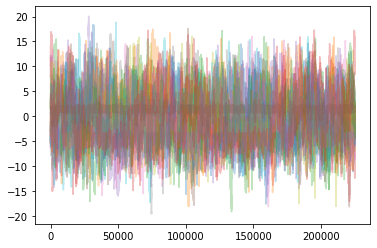

In [28]:
for i in range(16):
    plt.plot(samples_nn_HMC_converge[:,i], alpha = 0.3);

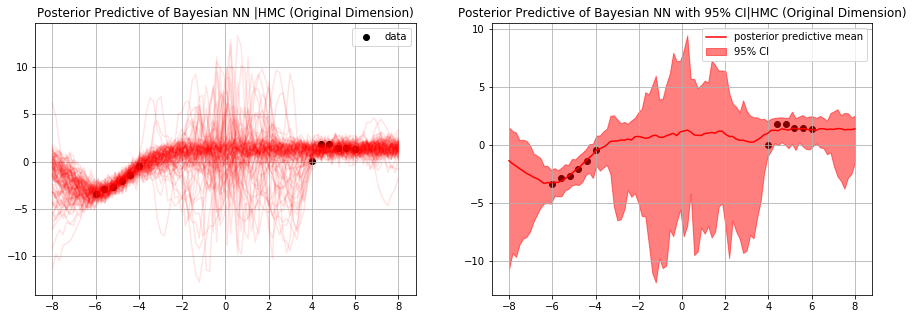

In [40]:
np.random.seed(2019)
n_sample = 100
sample_indices = np.random.choice(np.arange(len(samples_nn_HMC_converge)), n_sample)
sample = samples_nn_HMC_converge[sample_indices]

x_test = np.linspace(-8, 8, 100)
y_test_bnn = nn.forward(sample, x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, 0.5, size = (100, 100))

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC (Original Dimension)')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC (Original Dimension)')
plt.grid()
# plt.ylim(-15, 15)
plt.show()